# **1. Import Library**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
from pprint import pprint

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

# Optional advanced models
try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
    _HAS_LGBM = True
except Exception:
    _HAS_LGBM = False

try:
    import shap
    _HAS_SHAP = True
except Exception:
    _HAS_SHAP = False

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    _HAS_SMOTE = True
except Exception:
    _HAS_SMOTE = False

# Settings
RANDOM_STATE = 42
USE_SMOTE = True  # AKTIFKAN SMOTE
N_JOBS = -1
N_ITER_SEARCH = 40

# **2. Load Dataset**

In [2]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (1176, 36), Test shape: (294, 35)


# **3. Encoding**

In [3]:
# Target encoding
TARGET = 'Attrition'
if train[TARGET].dtype == 'object':
    train[TARGET] = train[TARGET].map(lambda x: 1 if str(x).strip().lower() in ['yes', '1', 'y', 'true'] else 0)

X = train.drop(columns=[TARGET])
y = train[TARGET]

# **4. Indentifikasi Var Numerik dan Kategorik**

In [4]:
# Identify numeric/categorical
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
print(f"Numeric cols: {len(num_cols)}, Cat cols: {len(cat_cols)}")

Numeric cols: 26, Cat cols: 9


# **5. Split Dataset**

In [5]:
# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

# **6. Preprocessing**

In [6]:
# Check missing value di df_train dan df_test
display(train.isnull().sum())
display(test.isnull().sum())

id                          0
Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

id                          0
Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [7]:
# Check duplikasi df_train dan df_test
display(train.duplicated().sum())
display(test.duplicated().sum())


np.int64(0)

np.int64(0)

In [8]:
# Preprocessing
num_trans = Pipeline([('imp', SimpleImputer(strategy='median')),
                      ('sc', StandardScaler())])
cat_trans = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preproc = ColumnTransformer([('num', num_trans, num_cols),
                             ('cat', cat_trans, cat_cols)])

def build_pipeline(model):
    if USE_SMOTE and _HAS_SMOTE:
        return ImbPipeline([
            ('preproc', preproc),
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('clf', model)
        ])
    else:
        return Pipeline([
            ('preproc', preproc),
            ('clf', model)
        ])
    

# **7. Best Model**

In [9]:
# Models + Search Space
models = {}

# Logistic Regression
lr = LogisticRegression(max_iter=2000, solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)
models['logistic'] = {
    'pipeline': build_pipeline(lr),
    'param_dist': {
        'clf__C': np.logspace(-3, 2, 10),
        'clf__penalty': ['l1', 'l2']
    }
}

# Random Forest
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
models['random_forest'] = {
    'pipeline': build_pipeline(rf),
    'param_dist': {
        'clf__n_estimators': [200, 400, 600],
        'clf__max_depth': [8, 12, 20, None],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    }
}

# XGBoost
if _HAS_XGB:
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=RANDOM_STATE)
    models['xgboost'] = {
        'pipeline': build_pipeline(xgb),
        'param_dist': {
            'clf__n_estimators': [200, 400],
            'clf__max_depth': [3, 5, 8],
            'clf__learning_rate': [0.01, 0.05, 0.1],
            'clf__subsample': [0.7, 0.9, 1.0],
            'clf__colsample_bytree': [0.6, 0.8, 1.0]
        }
    }

# LightGBM (optional)
if _HAS_LGBM:
    lgbm = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')
    models['lightgbm'] = {
        'pipeline': build_pipeline(lgbm),
        'param_dist': {
            'clf__n_estimators': [300, 500],
            'clf__max_depth': [-1, 8, 12],
            'clf__learning_rate': [0.01, 0.05, 0.1],
            'clf__num_leaves': [15, 31, 63],
            'clf__subsample': [0.7, 0.9, 1.0]
        }
    }


# **8. Training**

In [10]:
# =============================
# Training
# =============================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []

for name, spec in models.items():
    print(f"\n=== Training {name} ===")
    search = RandomizedSearchCV(
        estimator=spec['pipeline'],
        param_distributions=spec['param_dist'],
        n_iter=min(N_ITER_SEARCH, len(spec['param_dist'])*6),
        scoring='roc_auc',
        n_jobs=N_JOBS,
        cv=skf,
        verbose=1,
        random_state=RANDOM_STATE
    )
    search.fit(X_train, y_train)
    y_pred_proba = search.best_estimator_.predict_proba(X_val)[:,1]
    val_auc = roc_auc_score(y_val, y_pred_proba)
    results.append((name, val_auc, search.best_estimator_))
    print(f"Best CV AUC: {search.best_score_:.4f} | Val AUC: {val_auc:.4f}")
    print(f"Best params: {search.best_params_}")


=== Training logistic ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV AUC: 0.8329 | Val AUC: 0.8319
Best params: {'clf__penalty': 'l1', 'clf__C': np.float64(27.825594022071257)}

=== Training random_forest ===
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CV AUC: 0.8039 | Val AUC: 0.8448
Best params: {'clf__n_estimators': 400, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': 20}

=== Training xgboost ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV AUC: 0.8232 | Val AUC: 0.7952
Best params: {'clf__subsample': 0.7, 'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.8}

=== Training lightgbm ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 788, number of negative: 788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007608 seconds.
You can set `forc

# **9. Evaluasi**


Best model: random_forest | Validation ROC-AUC = 0.8448


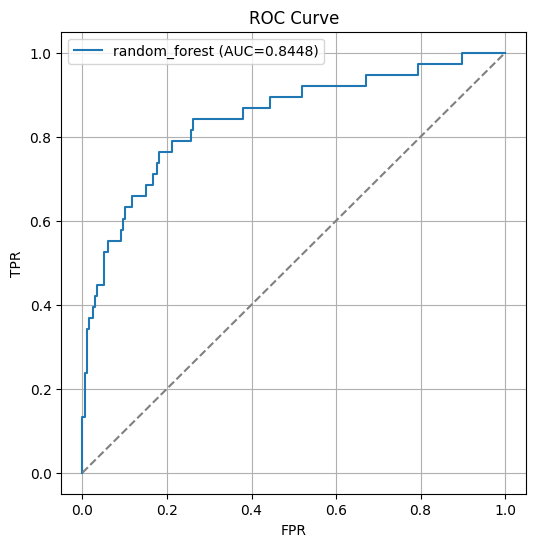

In [11]:
# =============================
# Evaluation
# =============================
results = sorted(results, key=lambda x: x[1], reverse=True)
best_name, best_auc, best_model = results[0]
print(f"\nBest model: {best_name} | Validation ROC-AUC = {best_auc:.4f}")

fpr, tpr, _ = roc_curve(y_val, best_model.predict_proba(X_val)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'{best_name} (AUC={best_auc:.4f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.legend(); plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.grid(True); plt.show()


# **10. Download File Submission**

In [12]:
#Download file submission 
if test is not None:
    print("\n=== Generating submission ===")
    preds = best_model.predict_proba(test)[:,1]
    
    # If original had an id column we removed, try to infer file id
    idcol = None
    for c in ['id', 'EmployeeNumber', 'employee_id', 'EmployeeID']:
        if c in pd.read_csv('train.csv').columns:
            idcol = c
            break

    submission = pd.DataFrame({'prediction': preds})
    if idcol is not None and idcol in pd.read_csv('test.csv').columns:
        submission[idcol] = pd.read_csv('test.csv')[idcol]
        submission = submission[[idcol, 'prediction']]
    out_path = 'submission_16.csv'
    submission.to_csv(out_path, index=False)
    print(f'Saved predictions to {out_path}')



=== Generating submission ===
Saved predictions to submission_16.csv
